In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    e = (np.sum((np.abs((zr-np.real(ztot)))))/(n*np.abs(zmag))) + \
        (np.sum((np.abs((zj-np.abs(np.imag(ztot))))))/(n*np.abs(zmag)))
    L1 = np.dot(e.T, e)
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
    plt.show()

    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x

    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()

    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()

def my_opt_fun_JADE(obj_function):
    # run differential evolution
    # solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
    #                          limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')
    return np.append(results_x, opts)
    
def my_opt_fun(obj_function):
    # run differential evolution
    solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
                             limits=bounds, minimize=True)
#     solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
#                         limits=bounds, minimize=True)
#     solver.c = np.random.random()
#     solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=4, JADE=True):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    if JADE:
        opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun_JADE)(obj_function) for _ in range(runs))  # noqa
    else:
        opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # Run the optimiziation
        # # generate fake results
        # zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])
        # peform the optimizations
        
        # reset data values
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # run normal optimizations
        xs_lk1_JADE, l1_opts_JADE, x_lk1_JADE, opt_lk1_JADE = opt_routine(otto_model_L1_Kait)
        xs_lk1_DE, l1_opts_DE, x_lk1_DE, opt_lk1_DE = opt_routine(otto_model_L1_Kait, JADE=False)

        xs_lk2_JADE, l2_opts_JADE, x_lk2_JADE, opt_lk2_JADE = opt_routine(otto_model_L2_Kait)
        xs_lk2_DE, l2_opts_DE, x_lk2_DE, opt_lk2_DE = opt_routine(otto_model_L2_Kait, JADE=False)
        break
    break


Optimization runtime 151.4547 seconds
Set of optima: [   5.45718474    5.45718474    5.45718474 1008.67230775    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474
 1019.48228955    5.45718476    5.45718474    5.45718474    5.45718474
    5.45718474    5.45718474 1019.48228955    5.45718474    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474
    5.45718474    5.45718474    5.45718474    5.45718474    5.45718474]
Best Objective value: 5.457184740418649
Paramters: [3.95510513e-01 6.39706173e-01 1.71947320e+00 1.00000000e-04
 1.00000000e+03] 



Optimization runtime 151.8781 seconds
Set of optima: [1019.48280523    5.45718491    5.45718476    5.45

# L1 Comparison of JADE vs DE

In [3]:
print('Best JADE function vlaue:', np.min(l1_opts_JADE))
print('Best DE function vlaue  :', np.min(l1_opts_DE), '\n')
print('Sum of JADE optima:', np.sum(l1_opts_JADE))
print('Sum of DE optima  :', np.sum(l1_opts_DE), '\n')
print('Mean of JADE optima:', np.mean(l1_opts_JADE))
print('Mean of DE optima  :', np.mean(l1_opts_DE), '\n')

Best JADE function vlaue: 5.457184740418649
Best DE function vlaue  : 5.457184502518442 

Sum of JADE optima: 3304.124569664982
Sum of DE optima  : 3358.008602323987 

Mean of JADE optima: 66.08249139329965
Mean of DE optima  : 67.16017204647974 



# L2 Comparison of JADE vs DE

In [4]:
print('Best JADE function vlaue:', np.min(l2_opts_JADE))
print('Best DE function vlaue  :', np.min(l2_opts_DE), '\n')
print('Sum of JADE optima:', np.sum(l2_opts_JADE))
print('Sum of DE optima  :', np.sum(l2_opts_DE), '\n')
print('Mean of JADE optima:', np.mean(l2_opts_JADE))
print('Mean of DE optima  :', np.mean(l2_opts_DE), '\n')

Best JADE function vlaue: 1214817349.7816377
Best DE function vlaue  : 1214817349.7816396 

Sum of JADE optima: 60740867489.081955
Sum of DE optima  : 6699881250064.603 

Mean of JADE optima: 1214817349.781639
Mean of DE optima  : 133997625001.29205 



In [5]:
def remove_outside_threshold(opt, xs, opts):
    # remove the functions outside 10% of the best objecjtive function
    ub = opt*1.1
    xz = []
    optz = []
    for i, j in enumerate(opts):
        if j <= ub:
            xz.append(xs[i])
            optz.append(opts[i])
    return np.array(xz), np.array(optz)


xs_lk1_JADE, l1_opts_JADE = remove_outside_threshold(opt_lk1_JADE, xs_lk1_JADE, l1_opts_JADE)
xs_lk1_DE, l1_opts_DE = remove_outside_threshold(opt_lk1_DE, xs_lk1_DE, l1_opts_DE)
xs_lk2_JADE, l2_opts_JADE = remove_outside_threshold(opt_lk2_JADE, xs_lk2_JADE, l2_opts_JADE)
xs_lk2_DE, l2_opts_DE = remove_outside_threshold(opt_lk2_DE, xs_lk2_DE, l2_opts_DE)

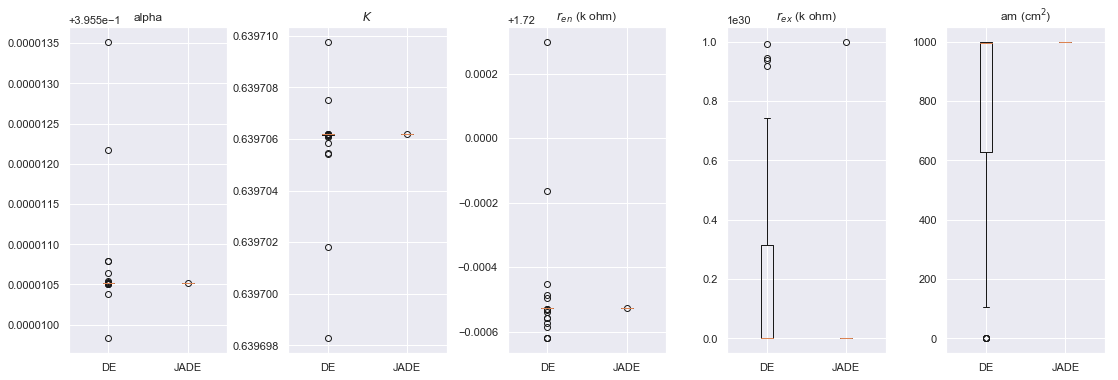

In [8]:
labels = ['alpha','$K$', r'$r_{en}$ (k ohm)', r'$r_{ex}$ (k ohm)', r'am (cm$^2$)']

fig, ax = plt.subplots(1, 5, sharey=False)
fig.set_size_inches(15, 5)
plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
for i in range(5):
    ax[i].boxplot([xs_lk1_DE[:, i], xs_lk1_JADE[:, i]])
    ax[i].set_xticklabels(['DE', 'JADE'])
    ax[i].set_title(labels[i])
plt.savefig('figs_JADE_vs_DE/lk1.pdf', bbox_inches='tight', dpi=300)


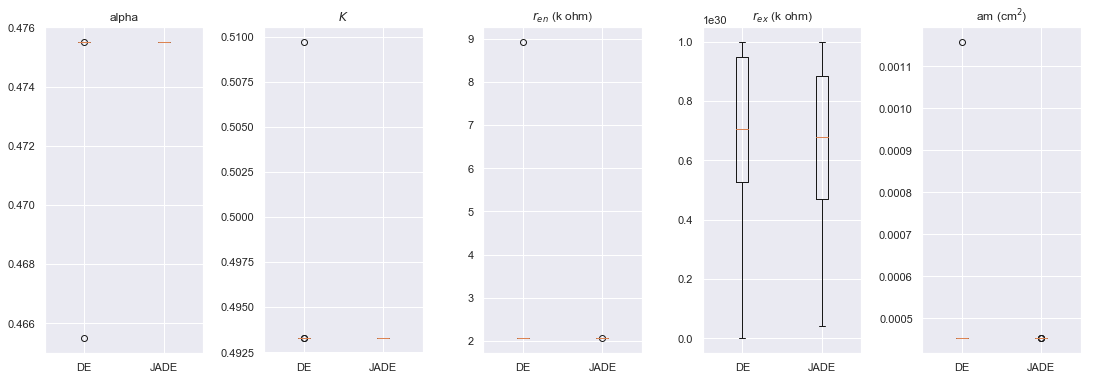

In [9]:
fig, ax = plt.subplots(1, 5, sharey=False)
fig.set_size_inches(15, 5)
plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
for i in range(5):
    ax[i].boxplot([xs_lk2_DE[:, i], xs_lk2_JADE[:, i]])
    ax[i].set_xticklabels(['DE', 'JADE'])
    ax[i].set_title(labels[i])
plt.savefig('figs_JADE_vs_DE/lk2.pdf', bbox_inches='tight', dpi=300)

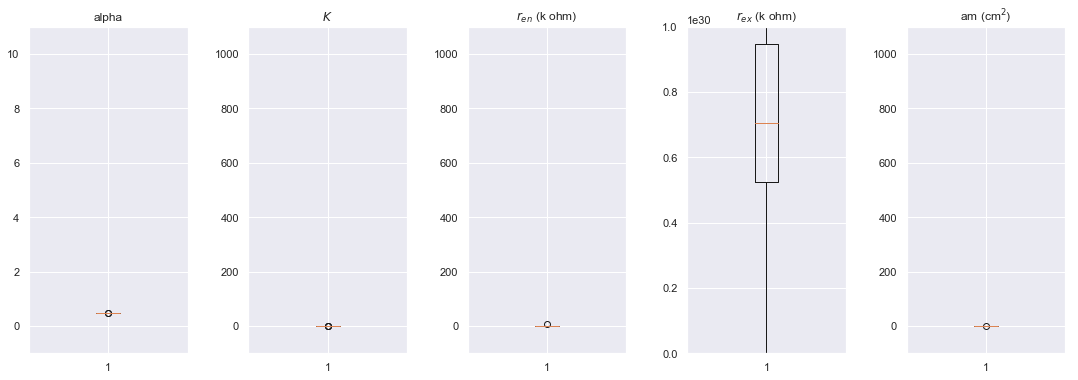

In [22]:
fig, ax = plt.subplots(1, 5, sharey=False)
fig.set_size_inches(15, 5)
plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=1.0)
for i in range(5):
    ax[i].boxplot(xs_lk2_DE[:, i])
    ax[i].set_title(labels[i])
    if i == 3:
        ax[i].set_ylim(bounds[i,0]-1e10, bounds[i,1]+1e10)
    elif i == 1 or i == 2 or i == 4:
        ax[i].set_ylim(bounds[i,0]-100, bounds[i,1]+100)
    else:
        ax[i].set_ylim(bounds[i,0]-1, bounds[i,1]+1)
plt.savefig('figs_JADE_vs_DE/lk2_de.pdf', bbox_inches='tight', dpi=300)